In [1]:
import os
import base64
import matplotlib.pyplot as plt
from mistralai import Mistral
import json
import pandas as pd
from typing import Union
import numpy as np
import secrets
import time
from concurrent.futures import ThreadPoolExecutor

pd.set_option('display.max_colwidth', None)
# Load Mistral API key from environment variables
api_key = "ZL4LdkeCwsoIYcNx2aFDujTYgpwj2kij"
# Initialize the Mistral client
client = Mistral(api_key=api_key)

### Generate wardrobes from database

In [2]:
def img_to_base64(image_path):
    """Input : image_path (str) : path to the image file
    Returns : image_base64 (str) : base64 encoded image"""
    
    with open(image_path, 'rb') as image_file:
        image_bytes = image_file.read()

    image_base64 = base64.b64encode(image_bytes).decode('utf-8')
    
    return image_base64

def json_to_dataframe(json_data: Union[str, dict], key: str = None) -> pd.DataFrame:
    # If json_data is a string, parse it into a dictionary
    if isinstance(json_data, str):
        json_data = json.loads(json_data)
    
    # If a key is provided, extract the list of records from the JSON object
    if key is not None:
        data = json_data[key]
    else:
        data = json_data
    
    # Convert the list of records to a pandas DataFrame
    df = pd.DataFrame(data)
    
    return df

def list_clothes(args): 
    image_base64, guide = args
    time.sleep(1)
    # Define the messages for the chat API
    messages = [
        {
            "role": "system",
            "content": "Return the answer in a JSON object with the next structure: "
                    "{\"elements\": [{\"element\": \"some name for element1\", "
                    "\"color\": \"the color of element1\", "
                    "\"fit\": \"the fit, shape of element1. Be concise.\", "
                    "\"price\": \"some number, estimated price of element1\", "
                    "\"context\": \"a word describing the occasion, mood or functionality of the piece\", "
                    "\"description\": \"a description of element1, emphasizing on the vibe of the piece and that encapsulates the precedent variables\"}, "
                    "{\"element\": \"some name for element2\", ...}]}"
        },
        {
            "role": "system",
            "content": f"You are a fashion critique, neutral and objective.\n\n {guide} \n\n You are presented with an image of an outfit, describe each of the elements thanks to your expertise "
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "image_url": f"data:image/jpeg;base64,{image_base64}"
                }
            ]
        }
    ]

    # Call the Mistral API to complete the chat
    chat_response = client.chat.complete(
        model="pixtral-12b-2409",
        messages=messages,
        temperature=0.4,
        response_format={
            "type": "json_object",
        }
    )

    # Get the content of the response
    content = chat_response.choices[0].message.content
    
    return content


In [3]:
desc_guide_path = "./desc_guide.txt"
critique_guide_path = "./critique_guide.txt"

with open(critique_guide_path, "rb") as f:
    critique_guide = f.read()

with open(desc_guide_path, "r") as f:
    desc_guide = f.read()

In [4]:
n_images=15
all_images = os.listdir("C:/Users/bapti/Documents/DATA/Cours/3A/Hackathon/fashion_images_dataset/")
n_images = np.random.choice(all_images, n_images, replace=False)
print(n_images)

['0970.jpg' '1073.jpg' '1090.jpg' '0369.jpg' '1272.jpg' '0693.jpg'
 '1995.jpg' '0525.jpg' '0859.jpg' '1418.jpg' '0017.jpg' '0689.jpg'
 '1899.jpg' '1357.jpg' '0949.jpg']


In [5]:
args_clothes = [(img_to_base64("C:/Users/bapti/Documents/DATA/Cours/3A/Hackathon/fashion_images_dataset/"+img), desc_guide) for img in n_images]

# Using ThreadPoolExecutor
with ThreadPoolExecutor(max_workers=8) as executor:
    # Submit tasks and collect results
    Wardrobes = list(executor.map(list_clothes, args_clothes))

### Suggest from wardrobe

In [140]:
def process_critique(args):
    time.sleep(1)
    wardrobe, guide, model = args
    
    chat_response = client.chat.complete(
        model=f"mistral-{model}-latest",
        messages=[
            {"role": "system", "content": f"As a 'Fashion Critique', your mission is to help relook people. \n\n {guide} \n\n You are given a description of items in an outfit. Give a critique of the outfit, outlining the general vibe, how the pieces work together and what could be improved."},
            {"role": "user", "content": '-'+'\n-'.join(wardrobe['description'])},
        ],
        temperature=0.2,
        max_tokens=2048
    )
    result = chat_response.choices[0].message.content

    return result

def recommend_item(args):
    time.sleep(1) 
    critique, guide, color_rule, piece_rule, element, model = args  
    # Define the messages for the chat API
    messages = [
        {
            "role": "system",
            "content": "Return the answer in a JSON object with the next structure: "
                    "{\"elements\": [{\"element\": \"some short name for element1\", "
                    "\"color\": \"the color of element1\", "
                    "\"fit\": \"the fit, shape of element1\", "
                    "\"price\": \"some number, estimated price of element1\", "
                    "\"context\": \"a word describing the occasion, mood or functionality of the piece\", "
                    "\"description\": \"a description of element1, emphasizing on the vibe of the piece and that encapsulates the precedent variables\"}]}"
        },
        {
            "role": "system",
            "content": f"You are a fashion critique, neutral and objective.\n\n {guide} \n\n You are presented with a critique of an outfit, describe a single element that would improve the outfit."
        },
        {
            "role": "system",
            "content": "Follow this rule when suggesting a piece of clothing: " + piece_rule
        },
        {
            "role": "system",
            "content": "Follow this rule when choosing a color: " + color_rule
        },
        {
            "role": "system",
            "content": "You will have to strictly follow these constraints when designing the item :" + str(element)
        },
        {
            "role": "user",
            "content": critique
        }
    ]

    # Call the Mistral API to complete the chat
    chat_response = client.chat.complete(
        model=f"mistral-{model}-latest",
        messages=messages,
        temperature=0.4,
        response_format={
            "type": "json_object",
        }
    )

    # Get the content of the response
    content = chat_response.choices[0].message.content
    
    return content

def recommend_from_wardrobe(args):
    time.sleep(1)
    wardrobe, element, critique_guide, desc_guide = args
    model="large"
    color_rules = np.random.choice([ 
                                "complementary colors: colors that are opposite on the color wheel", 
                                "analogus colors: colors that are close on the color wheel", 
                                "accent color: one bright color that pops from the rest that are neutral", 
                                "sandwiching: layering a bright color between two neutral colors",
                                "monochromatic: using different shades of the same color to create a cohesive look",
                                "pattern mixing: combining different patterns to create a unique outfit",
                                "seasonal: using seasonal colors and pieces to create a weather-appropriate outfit",
                                            ])
            
    piece_rules = np.random.choice([
                                    "mixing textures: incorporating different textures to add visual interest",
                                    "statement piece: building an outfit around a bold statement piece",
                                    "proportion balance: suggest a piece with a fit that balances the outfit", 
                                    "accessories: adding an accessory to elevate the outfit",
                                    "silouhette: creating a visually interesting shape with the outfit",
                                    "replacement: suggesting a piece that would replace a current piece in the outfit",
                                    "layering: adding a layer to the outfit to create depth, like a coat or jacket",
                                    "adding surface: suggest a pig piece with a different surface, like a shiny or matte fabric"
                                        ])
    
    critique = process_critique((wardrobe, critique_guide, model))
    content = recommend_item((critique, desc_guide, color_rules, piece_rules, element, model))
    
    return content

In [156]:
element = {"element":"running shoes", "color":None, "fit":None, "price":None, "context":None, "description":None}
print(str(element))
img=1
wardrobe_df = json_to_dataframe(Wardrobes[img],key='elements')
content_large = recommend_from_wardrobe((wardrobe_df, element, critique_guide, desc_guide))
content_df = json_to_dataframe(content_large, key='elements')

{'element': 'running shoes', 'color': None, 'fit': None, 'price': None, 'context': None, 'description': None}


,element,color,fit,price,context,description
0,White Polo Shirt,White,"Relaxed, casual fit with short sleeves",Estimated $20-$40,"Casual, everyday wear","A classic white polo shirt with a relaxed fit, perfect for casual outings and comfortable wear."
1,Red Tie with White Polka Dots,Red with white polka dots,"Narrow and long, suitable for tucking into pants",Estimated $15-$30,"Casual yet stylish, suitable for semi-formal occasions","A red tie with white polka dots adds a playful yet sophisticated touch to the outfit, enhancing the casual yet stylish vibe."
2,Gray Chino Pants,Gray,Slim fit with a slight taper towards the ankle,Estimated $30-$50,"Casual, everyday wear","Gray chino pants with a slim fit provide a balanced look, combining comfort and style for casual outings."
3,Red High-Top Sneakers,Red,High-top design with a sporty look,Estimated $50-$80,"Casual, streetwear style","Red high-top sneakers add a bold, sporty touch to the outfit, emphasizing a casual and vibrant streetwear style."


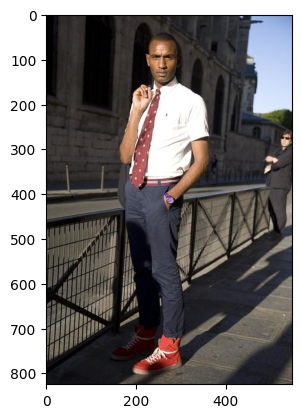

In [154]:
plt.imshow(plt.imread("C:/Users/bapti/Documents/DATA/Cours/3A/Hackathon/fashion_images_dataset/"+n_images[img]))
wardrobe_df

In [157]:
content_df

,element,color,fit,price,context,description
0,running shoes,"a bold, vibrant shade of red with white accents to complement the existing color palette and reinforce the playful, streetwear-inspired vibe","a sleek, streamlined silhouette with a snug, sock-like upper for a modern, athletic look",120,energetic,"A statement pair of running shoes featuring a bold, vibrant shade of red with white accents, designed with a sleek, streamlined silhouette and a snug, sock-like upper. The dynamic color combination and modern, athletic fit create an energetic vibe, perfect for enhancing a playful, streetwear-inspired outfit while maintaining a sporty, on-the-go edge."
